In [1]:
import importlib
import model.UnsuperviedLearner as cl
importlib.reload(module=cl)
import sklearn.datasets as ds
import sklearn.preprocessing as pre
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as mc
import torch
from torch import nn

In [78]:
n_clusters = np.arange(2,70,1)
model = cl.HDBSCAN(metric='euclidean', min_cluster_size=5, min_samples=5, cluster_selection_method='leaf')
circle_data = ds.make_blobs(n_samples=2000, n_features=2, centers=5, cluster_std=0.5, random_state=0)
data,label = circle_data
data = pd.DataFrame(data)
data.head()

,0,1
0,-2.429530,3.333075
1,0.942149,5.160459
2,-0.826142,2.997099
3,10.030346,-2.215660
4,-2.044707,2.988716


In [79]:
model.fit(data)
sih_score = model.scores_
precision= mc.precision_score(label, model.labels_,average='macro')
recall = mc.recall_score(label, model.labels_,average='macro')
f1 = mc.f1_score(label, model.labels_,average='macro')
accuracy = mc.accuracy_score(label, model.labels_)
results={'sih_score':sih_score, 
         'precision':precision, 
         'recall':recall, 
         'f1':f1, 
         'accuracy':accuracy}
results = pd.Series(results).round(3)
results

sih_score    0.763
precision    0.000
recall       0.000
f1           0.000
accuracy     0.000
dtype: float64

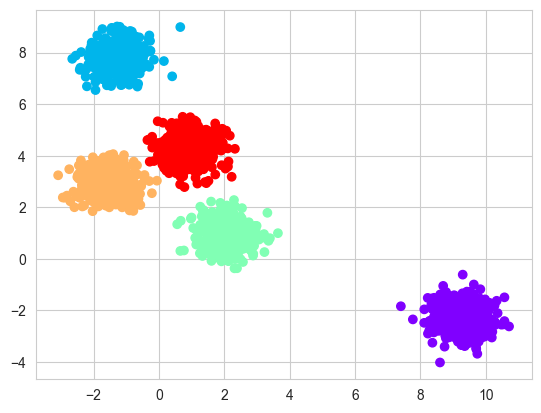

In [80]:
model.fit(data)
plt.scatter(data.iloc[:,0], data.iloc[:,1],c=model.labels_, cmap='rainbow')
plt.show()

In [2]:
data = ds.load_breast_cancer(as_frame=True)
x = data.data
feat_cols = x.columns
y = data.target
del data
y.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [19]:
class autoencoder(nn.Module):
    def __init__(self,embedding_dim=5):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, embedding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 30),
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.values).to(torch.float64)
        self.y = torch.from_numpy(y.values).to(torch.float64).ravel()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def factor_gen(x,y):
    x = pre.RobustScaler().fit_transform(x)
    x = pd.DataFrame(x, columns=feat_cols)
    model = autoencoder(embedding_dim=30).to(torch.float64)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion1 = nn.MSELoss()
    epochs = 5000
    batch_size = 600
    train_data = mydata(x,y)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for train_X,train_y in train_loader:
            optimizer.zero_grad()
            output = model(train_X)
            loss1 = criterion1(output, train_X)
            loss1.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss1.item()))
    model.eval()
    embedding = model.encoder(torch.from_numpy(x.values).to(torch.float64))
    embedding = embedding.detach().numpy()
    embedding = pd.DataFrame(embedding,columns=['embed_'+str(i+1) for i in range(embedding.shape[1])])
    embed_mean = embedding.mean(0)
    mask = embed_mean>0.5
    embedding = embedding
    return embedding,model.encoder,mask

In [21]:
import lightgbm as lgb
import sklearn.model_selection as ms
from sklearn.utils._joblib import Parallel, delayed
lgb_model = lgb.LGBMClassifier(n_estimators=150, max_depth=5, num_leaves=10, learning_rate=0.1, random_state=0)

def test_func(x,y):
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25)
    embed,encoder,mask = factor_gen(x_train,y_train)
    embed = embed.loc[:,mask].reset_index(drop=True)
    x_train = x_train.reset_index(drop=True)
    lgb_model.fit(x_train, y_train)
    y_pred = lgb_model.predict(x_test)
    no_embed_acc = mc.accuracy_score(y_test, y_pred)
    x_train = pd.concat([x_train,embed],axis=1)
    encoder.eval()
    x_test_embed = encoder(torch.from_numpy(x_test.values).to(torch.float64))
    x_test_embed = x_test_embed.detach().numpy()
    x_test_embed = pd.DataFrame(x_test_embed,columns=['embed_'+str(i+1) for i in range(x_test_embed.shape[1])])
    x_test_embed = x_test_embed.loc[:,mask].reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    x_test = pd.concat([x_test,x_test_embed],axis=1)
    lgb_model.fit(x_train, y_train)
    y_pred = lgb_model.predict(x_test)
    embed_acc = mc.accuracy_score(y_test, y_pred)
    return embed_acc>no_embed_acc

results = Parallel(n_jobs=-1)(delayed(test_func)(x,y) for i in range(100))
sum(results)/len(results)

In [16]:
import pandas as pd
import modin.pandas as mpd
import os
os.environ['MODIN_ENGINE'] = 'dask'
os.environ['MODIN_CPUS'] = '8'
path = r"C:\Users\JIN NING\Desktop\进度.xlsx"
data = pd.read_excel(path, sheet_name='Sheet1')

In [44]:
import imblearn as imb
import pandas as pd
from imblearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
data = ds.fetch_datasets()['ecoli']
x,y = data.data, data.target
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [46]:
model1 = imb.ensemble.BalancedRandomForestClassifier(n_estimators=100, 
                                                    max_depth=5, 
                                                    min_samples_leaf=10,
                                                    max_samples=0.7,
                                                    max_leaf_nodes=30)
model2 = RandomForestClassifier(n_estimators=100, 
                                max_depth=5, 
                                min_samples_leaf=10,
                                max_samples=0.7,
                                max_leaf_nodes=30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)
print(accuracy_score(y_test, y_pred1),balanced_accuracy_score(y_test, y_pred1))
print(accuracy_score(y_test, y_pred2),balanced_accuracy_score(y_test, y_pred2))

0.8214285714285714 0.8376623376623377
0.9166666666666666 0.5


In [17]:
from PIL import Image

def compress_image(input_dir, output_dir, r):
    try:
        # 打开输入图片
        image = Image.open(input_dir)

        # 获取原始图片的宽度和高度
        width, height = image.size

        # 计算压缩后的宽度和高度
        new_width = int(width * r)
        new_height = int(height * r)

        # 使用thumbnail方法进行图片压缩
        image.thumbnail((new_width, new_height))

        # 保存压缩后的图片到输出目录
        image.save(output_dir, "JPEG")

        # 返回成功的消息
        return "压缩成功"

    except Exception as e:
        return str(e)